In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
tf.test.is_gpu_available()

True

In [3]:
def show_images(images, nrof_columns):
    batch, width, height, depth = images.shape
    nrof_rows = int(np.ceil(batch/nrof_columns)) 
    out = np.zeros((nrof_rows*height, nrof_columns*width, depth), dtype=np.float32)
    for i in range(batch):
        x = i % nrof_columns
        y = i // nrof_columns
        out[y*height:(y+1)*height,x*width:(x+1)*width,:] = images[i,:,:,:]
    out[0::height,:,:] = 1.0
    out[:,0::width,:] = 1.0
    out[1::height,:,:] = 1.0
    out[:,1::width,:] = 1.0
    plt.imshow(out)

In [4]:
with open('hw3-q2.pkl', 'rb') as f:
    x = pickle.load(f)

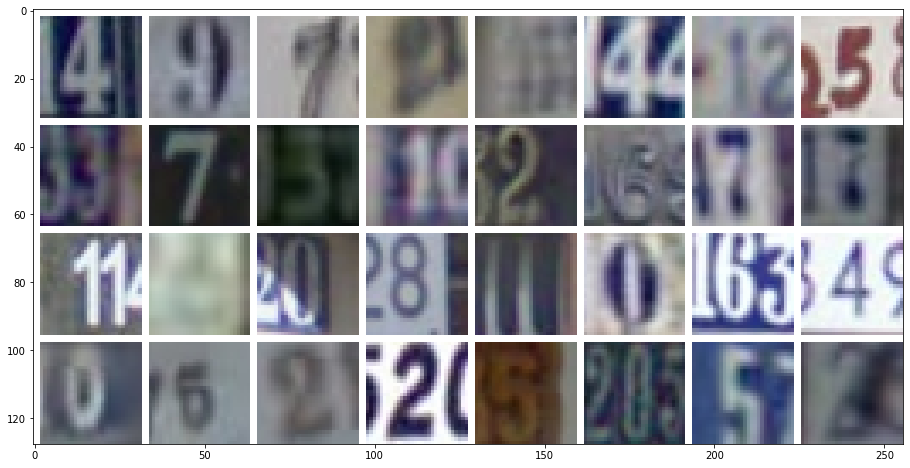

In [5]:
plt.figure(figsize=(16,8))
show_images(x['train'][:32,...]/256, 8)

In [6]:
def softlimit(x, limit=0.1):
    return tf.math.log(tf.math.exp(x) + 1.0 + limit)

def dense(x, nrof_units, activation=None, training=True, use_batch_norm=False):
    x = tf.compat.v1.layers.Flatten()(x)
    x = tf.compat.v1.layers.Dense(units=nrof_units)(x)
    if use_batch_norm:
        x = tf.compat.v1.layers.BatchNormalization()(x, training=training)
    x = x if activation is None else activation(x)
    return x

def mlp(x, nrof_units, activation, nrof_layers=1, training=True):
    for _ in range(nrof_layers):
        x = dense(x, nrof_units=nrof_units, activation=activation, training=training)
    return x

def sample(mu, sigma):
    epsilon = tf.random.normal(tf.shape(sigma), mean=0.0, stddev=1.0)
    return mu + sigma*epsilon

def log_normal(x, mean, log_var, eps=1e-5):
    with tf.variable_scope('log_normal'):
        c = - 0.5 * np.log(2*np.pi)
        return c - log_var/2 - (x - mean)**2 / (2 * tf.math.exp(log_var) + eps)
    
def get_warmup_temp(epoch, nrof_warmup_epochs):
    if nrof_warmup_epochs>0:
        temp = np.minimum(1.0, 1.0/nrof_warmup_epochs * (epoch-1))
    else:
        temp = 1.0
    return temp

In [7]:
def residual_stack(x, scope):
    with tf.variable_scope(scope):
        for i in range(5):
            x = tf.nn.relu(x)
            x = tf.layers.conv2d(x, filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same')
            x = tf.nn.relu(x)
            x = tf.layers.conv2d(x, filters=64*2, kernel_size=(3, 3), strides=(1, 1), padding='same')
        x = tf.nn.relu(x)
    return x

In [8]:
def create_dataset(x, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(x)
    dataset = dataset.repeat()   # Repeat the dataset indefinitely
    dataset = dataset.shuffle(10000)   # Shuffle the data
    dataset = dataset.batch(batch_size)  # Create batches of data
    dataset = dataset.prefetch(batch_size)  # Prefetch data for faster consumption
    iterator = tf.compat.v1.data.make_initializable_iterator(dataset)  # Create an iterator over the dataset
    return iterator

In [9]:
def vae(x, temp, latent_nrof_channels, is_training):
    dbg = dict()
    
    dbg['x'] = x
    h = x

    with tf.variable_scope('encoder'):
        h = tf.layers.conv2d(h, filters=128, kernel_size=(4, 4), strides=(2, 2), padding='same')
        h = tf.nn.relu(h)
        h = tf.layers.conv2d(h, filters=256, kernel_size=(4, 4), strides=(2, 2), padding='same')
        h = tf.nn.relu(h)
        h = tf.layers.conv2d(h, filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same')
        h = residual_stack(h, 'res_stack')

        q_mu = tf.layers.conv2d(h, filters=latent_nrof_channels, kernel_size=(1, 1), strides=(1, 1), padding='same')
        q_sigma = softlimit(tf.layers.conv2d(h, filters=latent_nrof_channels, kernel_size=(1, 1), strides=(1, 1), padding='same'))
        dbg['q_mu'] = q_mu
        dbg['q_sigma'] = q_sigma
        

    with tf.variable_scope('decoder'):
        z = sample(q_mu, q_sigma)
        dbg['z'] = z
        h = z
        print('q_mu', q_mu)
        print('h', h)
        h = tf.layers.conv2d(h, filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same')
        h = residual_stack(h, 'res_stack')
        h = tf.layers.conv2d_transpose(h, filters=128, kernel_size=(4, 4), strides=(2, 2), padding='same')
        h = tf.nn.relu(h)
        h = tf.layers.conv2d_transpose(h, filters=128, kernel_size=(4, 4), strides=(2, 2), padding='same')

        x_rec_mu = tf.layers.conv2d(h, filters=3, kernel_size=(1, 1), strides=(1, 1), padding='same')
        x_rec_sigma = softlimit(tf.layers.conv2d(h, filters=3, kernel_size=(1, 1), strides=(1, 1), padding='same'))
        dbg['x_rec_mu'] = x_rec_mu
        dbg['x_rec_sigma'] = x_rec_sigma
        
    with tf.variable_scope('rec_loss'):
        log_pxz = log_normal(x, x_rec_mu, tf.math.log(x_rec_sigma)*2)
        dbg['log_pxz'] = tf.reduce_mean(log_pxz) * np.log2(np.e)
    
    with tf.variable_scope('reg_loss'):
        p_mu, p_sigma = tf.zeros_like(q_mu), tf.ones_like(q_sigma)
        log_qz = log_normal(z, q_mu, tf.math.log(q_sigma)*2)
        log_pz = log_normal(z, p_mu, tf.math.log(p_sigma)*2)
        dbg['log_pzx'] = tf.reduce_mean(log_pz - log_qz) * np.log2(np.e)
    
    with tf.variable_scope('elbo'):
        print('log_pxz', log_pxz)
        print('log_qz', log_qz)
        elbo = (tf.reduce_mean(log_pxz) + temp*tf.reduce_mean(log_pz-log_qz)) * np.log2(np.e)
        
    dbg['elbo'] = elbo
    loss = -elbo

    return loss, dbg

In [10]:
def evaluate(dbg, input_ph, x, batch_size=256):
    elbo_list, log_pxz_list, log_pzx_list = [], [], []
    nrof_batches = int(np.ceil(x.shape[0] / batch_size))
    for i in range(nrof_batches):
        batch_start = i*batch_size
        batch_end = np.minimum(batch_start+batch_size, x.shape[0])
        dbg_ = sess.run(dbg, feed_dict={input_ph:x[batch_start:batch_end,...], temp_ph:1.0})
        elbo_list += [ dbg_['elbo'] ]
        log_pxz_list += [ dbg_['log_pxz'] ]
        log_pzx_list += [ dbg_['log_pzx'] ]
    return np.mean(elbo_list), np.mean(log_pxz_list), np.mean(log_pzx_list)

In [16]:
nrof_epochs = 100
batch_size = 128
nrof_warmup_epochs = 10
latent_nrof_channels = 8

tf.set_random_seed(42)
np.random.seed(42)

tf.reset_default_graph()
with tf.Graph().as_default():
    train_iterator = create_dataset(x['train'].astype(np.float32)/256, batch_size)
    eval_input_ph = tf.placeholder(tf.float32, shape=(None,32,32,3))
    temp_ph = tf.placeholder(tf.float32, shape=())

    with tf.variable_scope('model', reuse=False):
        train_loss, train_dbg = vae(train_iterator.get_next(), temp_ph, latent_nrof_channels=latent_nrof_channels, is_training=True)
    with tf.variable_scope('model', reuse=True):
        _, eval_dbg = vae(eval_input_ph, temp_ph, latent_nrof_channels=latent_nrof_channels, is_training=False)

    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    train_op = optimizer.minimize(train_loss)

    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    sess.run(train_iterator.initializer)

    nrof_batches = x['train'].shape[0] // batch_size

    train_elbo_list, train_log_pxz_list, train_log_pzx_list = [], [], []
    eval_elbo_list, eval_log_pxz_list, eval_log_pzx_list = [], [], []
    for epoch in range(1, nrof_epochs+1):
        temp = get_warmup_temp(epoch, nrof_warmup_epochs)
        for i in range(nrof_batches):
            _, loss_, dbg_ = sess.run([train_op, train_loss, train_dbg], feed_dict={temp_ph:temp})
            train_elbo_list += [ dbg_['elbo'] ]
            train_log_pxz_list += [ dbg_['log_pxz'] ]
            train_log_pzx_list += [ dbg_['log_pzx'] ]
            if i % 25 == 0:
                print('train epoch: %4d  batch: %4d  temp: %7.3f  elbo: %7.3f  p(x|z): %7.3f  p(z|x): %7.3f' % (
                    epoch, i, temp, dbg_['elbo'], dbg_['log_pxz'], dbg_['log_pzx']))

        elbo, log_pxz, log_pzx = evaluate(eval_dbg, eval_input_ph, x['valid'].astype(np.float32)/256)
        print('val epoch:   %4d  elbo: %7.3f  p(x|z): %7.3f  p(z|x): %7.3f' % (epoch, elbo, log_pxz, log_pzx))
        eval_elbo_list += [ elbo ]
        eval_log_pxz_list += [ log_pxz ]
        eval_log_pzx_list += [ log_pzx ]

    elbo, log_pxz, log_pzx = evaluate(eval_dbg, eval_input_ph, x['test'].astype(np.float32)/256)
    print('test epoch:  %4d  elbo: %7.3f  p(x|z): %7.3f  p(z|x): %7.3f' % (epoch, elbo, log_pxz, log_pzx))

q_mu Tensor("model/encoder/conv2d_3/BiasAdd:0", shape=(?, 8, 8, 8), dtype=float32)
h Tensor("model/decoder/add:0", shape=(?, 8, 8, 8), dtype=float32)
log_pxz Tensor("model/rec_loss/log_normal/sub_2:0", shape=(?, 32, 32, 3), dtype=float32)
log_qz Tensor("model/reg_loss/log_normal/sub_2:0", shape=(?, 8, 8, 8), dtype=float32)
q_mu Tensor("model_1/encoder/conv2d_3/BiasAdd:0", shape=(?, 8, 8, 8), dtype=float32)
h Tensor("model_1/decoder/add:0", shape=(?, 8, 8, 8), dtype=float32)
log_pxz Tensor("model_1/rec_loss/log_normal/sub_2:0", shape=(?, 32, 32, 3), dtype=float32)
log_qz Tensor("model_1/reg_loss/log_normal/sub_2:0", shape=(?, 8, 8, 8), dtype=float32)


/home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


train epoch:    1  batch:    0  temp:   0.000  elbo:  -1.185  p(x|z):  -1.185  p(z|x):  -0.106
train epoch:    1  batch:   25  temp:   0.000  elbo:  -0.638  p(x|z):  -0.638  p(z|x):  -0.098
train epoch:    1  batch:   50  temp:   0.000  elbo:   0.128  p(x|z):   0.128  p(z|x):  -0.150
train epoch:    1  batch:   75  temp:   0.000  elbo:   0.522  p(x|z):   0.522  p(z|x):  -0.785
train epoch:    1  batch:  100  temp:   0.000  elbo:  -0.425  p(x|z):  -0.425  p(z|x):  -1.036
train epoch:    1  batch:  125  temp:   0.000  elbo:   0.617  p(x|z):   0.617  p(z|x):  -0.964
train epoch:    1  batch:  150  temp:   0.000  elbo:   0.702  p(x|z):   0.702  p(z|x):  -1.430
train epoch:    1  batch:  175  temp:   0.000  elbo:   0.688  p(x|z):   0.688  p(z|x):  -1.587
train epoch:    1  batch:  200  temp:   0.000  elbo:   0.836  p(x|z):   0.836  p(z|x):  -1.603
train epoch:    1  batch:  225  temp:   0.000  elbo:   0.847  p(x|z):   0.847  p(z|x):  -1.664
train epoch:    1  batch:  250  temp:   0.000  elb

train epoch:    5  batch:   25  temp:   0.400  elbo:   1.495  p(x|z):   1.591  p(z|x):  -0.240
train epoch:    5  batch:   50  temp:   0.400  elbo:   1.465  p(x|z):   1.563  p(z|x):  -0.244
train epoch:    5  batch:   75  temp:   0.400  elbo:   1.449  p(x|z):   1.553  p(z|x):  -0.261
train epoch:    5  batch:  100  temp:   0.400  elbo:   1.310  p(x|z):   1.410  p(z|x):  -0.249
train epoch:    5  batch:  125  temp:   0.400  elbo:   1.447  p(x|z):   1.549  p(z|x):  -0.255
train epoch:    5  batch:  150  temp:   0.400  elbo:   1.505  p(x|z):   1.607  p(z|x):  -0.254
train epoch:    5  batch:  175  temp:   0.400  elbo:   1.400  p(x|z):   1.499  p(z|x):  -0.248
train epoch:    5  batch:  200  temp:   0.400  elbo:   1.493  p(x|z):   1.587  p(z|x):  -0.236
train epoch:    5  batch:  225  temp:   0.400  elbo:   1.422  p(x|z):   1.524  p(z|x):  -0.255
train epoch:    5  batch:  250  temp:   0.400  elbo:   1.431  p(x|z):   1.526  p(z|x):  -0.239
train epoch:    5  batch:  275  temp:   0.400  elb

train epoch:    9  batch:   25  temp:   0.800  elbo:   1.574  p(x|z):   1.727  p(z|x):  -0.190
train epoch:    9  batch:   50  temp:   0.800  elbo:   1.581  p(x|z):   1.728  p(z|x):  -0.184
train epoch:    9  batch:   75  temp:   0.800  elbo:   1.517  p(x|z):   1.672  p(z|x):  -0.194
train epoch:    9  batch:  100  temp:   0.800  elbo:   1.544  p(x|z):   1.699  p(z|x):  -0.193
train epoch:    9  batch:  125  temp:   0.800  elbo:   1.501  p(x|z):   1.656  p(z|x):  -0.195
train epoch:    9  batch:  150  temp:   0.800  elbo:   1.541  p(x|z):   1.691  p(z|x):  -0.188
train epoch:    9  batch:  175  temp:   0.800  elbo:   1.526  p(x|z):   1.676  p(z|x):  -0.188
train epoch:    9  batch:  200  temp:   0.800  elbo:   1.578  p(x|z):   1.728  p(z|x):  -0.188
train epoch:    9  batch:  225  temp:   0.800  elbo:   1.521  p(x|z):   1.674  p(z|x):  -0.191
train epoch:    9  batch:  250  temp:   0.800  elbo:   1.554  p(x|z):   1.704  p(z|x):  -0.188
train epoch:    9  batch:  275  temp:   0.800  elb

train epoch:   13  batch:   25  temp:   1.000  elbo:   1.529  p(x|z):   1.705  p(z|x):  -0.176
train epoch:   13  batch:   50  temp:   1.000  elbo:   1.470  p(x|z):   1.644  p(z|x):  -0.174
train epoch:   13  batch:   75  temp:   1.000  elbo:   1.590  p(x|z):   1.759  p(z|x):  -0.169
train epoch:   13  batch:  100  temp:   1.000  elbo:   1.538  p(x|z):   1.711  p(z|x):  -0.173
train epoch:   13  batch:  125  temp:   1.000  elbo:   1.590  p(x|z):   1.759  p(z|x):  -0.170
train epoch:   13  batch:  150  temp:   1.000  elbo:   1.509  p(x|z):   1.683  p(z|x):  -0.174
train epoch:   13  batch:  175  temp:   1.000  elbo:   1.545  p(x|z):   1.718  p(z|x):  -0.174
train epoch:   13  batch:  200  temp:   1.000  elbo:   1.550  p(x|z):   1.717  p(z|x):  -0.167
train epoch:   13  batch:  225  temp:   1.000  elbo:   1.555  p(x|z):   1.733  p(z|x):  -0.178
train epoch:   13  batch:  250  temp:   1.000  elbo:   1.519  p(x|z):   1.695  p(z|x):  -0.176
train epoch:   13  batch:  275  temp:   1.000  elb

train epoch:   17  batch:   25  temp:   1.000  elbo:   1.576  p(x|z):   1.758  p(z|x):  -0.182
train epoch:   17  batch:   50  temp:   1.000  elbo:   1.536  p(x|z):   1.711  p(z|x):  -0.175
train epoch:   17  batch:   75  temp:   1.000  elbo:   1.562  p(x|z):   1.737  p(z|x):  -0.175
train epoch:   17  batch:  100  temp:   1.000  elbo:   1.585  p(x|z):   1.761  p(z|x):  -0.176
train epoch:   17  batch:  125  temp:   1.000  elbo:   1.606  p(x|z):   1.779  p(z|x):  -0.173
train epoch:   17  batch:  150  temp:   1.000  elbo:   1.588  p(x|z):   1.764  p(z|x):  -0.175
train epoch:   17  batch:  175  temp:   1.000  elbo:   1.462  p(x|z):   1.645  p(z|x):  -0.183
train epoch:   17  batch:  200  temp:   1.000  elbo:   1.589  p(x|z):   1.757  p(z|x):  -0.168
train epoch:   17  batch:  225  temp:   1.000  elbo:   1.619  p(x|z):   1.788  p(z|x):  -0.169
train epoch:   17  batch:  250  temp:   1.000  elbo:   1.576  p(x|z):   1.753  p(z|x):  -0.177
train epoch:   17  batch:  275  temp:   1.000  elb

train epoch:   21  batch:   25  temp:   1.000  elbo:   1.617  p(x|z):   1.789  p(z|x):  -0.172
train epoch:   21  batch:   50  temp:   1.000  elbo:   1.564  p(x|z):   1.735  p(z|x):  -0.171
train epoch:   21  batch:   75  temp:   1.000  elbo:   1.578  p(x|z):   1.762  p(z|x):  -0.184
train epoch:   21  batch:  100  temp:   1.000  elbo:   1.623  p(x|z):   1.795  p(z|x):  -0.172
train epoch:   21  batch:  125  temp:   1.000  elbo:   1.592  p(x|z):   1.775  p(z|x):  -0.184
train epoch:   21  batch:  150  temp:   1.000  elbo:   1.584  p(x|z):   1.762  p(z|x):  -0.178
train epoch:   21  batch:  175  temp:   1.000  elbo:   1.620  p(x|z):   1.793  p(z|x):  -0.173
train epoch:   21  batch:  200  temp:   1.000  elbo:   1.519  p(x|z):   1.699  p(z|x):  -0.180
train epoch:   21  batch:  225  temp:   1.000  elbo:   1.585  p(x|z):   1.775  p(z|x):  -0.190
train epoch:   21  batch:  250  temp:   1.000  elbo:   1.605  p(x|z):   1.784  p(z|x):  -0.179
train epoch:   21  batch:  275  temp:   1.000  elb

train epoch:   25  batch:   25  temp:   1.000  elbo:   1.621  p(x|z):   1.799  p(z|x):  -0.178
train epoch:   25  batch:   50  temp:   1.000  elbo:   1.640  p(x|z):   1.813  p(z|x):  -0.174
train epoch:   25  batch:   75  temp:   1.000  elbo:   1.574  p(x|z):   1.747  p(z|x):  -0.173
train epoch:   25  batch:  100  temp:   1.000  elbo:   1.581  p(x|z):   1.764  p(z|x):  -0.183
train epoch:   25  batch:  125  temp:   1.000  elbo:   1.618  p(x|z):   1.794  p(z|x):  -0.176
train epoch:   25  batch:  150  temp:   1.000  elbo:   1.643  p(x|z):   1.814  p(z|x):  -0.171
train epoch:   25  batch:  175  temp:   1.000  elbo:   1.659  p(x|z):   1.824  p(z|x):  -0.165
train epoch:   25  batch:  200  temp:   1.000  elbo:   1.624  p(x|z):   1.796  p(z|x):  -0.172
train epoch:   25  batch:  225  temp:   1.000  elbo:   1.615  p(x|z):   1.789  p(z|x):  -0.174
train epoch:   25  batch:  250  temp:   1.000  elbo:   1.628  p(x|z):   1.803  p(z|x):  -0.175
train epoch:   25  batch:  275  temp:   1.000  elb

train epoch:   29  batch:   25  temp:   1.000  elbo:   1.619  p(x|z):   1.800  p(z|x):  -0.182
train epoch:   29  batch:   50  temp:   1.000  elbo:   1.579  p(x|z):   1.760  p(z|x):  -0.181
train epoch:   29  batch:   75  temp:   1.000  elbo:   1.639  p(x|z):   1.814  p(z|x):  -0.174
train epoch:   29  batch:  100  temp:   1.000  elbo:   1.633  p(x|z):   1.810  p(z|x):  -0.178
train epoch:   29  batch:  125  temp:   1.000  elbo:   1.609  p(x|z):   1.783  p(z|x):  -0.174
train epoch:   29  batch:  150  temp:   1.000  elbo:   1.620  p(x|z):   1.796  p(z|x):  -0.176
train epoch:   29  batch:  175  temp:   1.000  elbo:   1.616  p(x|z):   1.790  p(z|x):  -0.175
train epoch:   29  batch:  200  temp:   1.000  elbo:   1.638  p(x|z):   1.813  p(z|x):  -0.175
train epoch:   29  batch:  225  temp:   1.000  elbo:   1.647  p(x|z):   1.813  p(z|x):  -0.167
train epoch:   29  batch:  250  temp:   1.000  elbo:   1.584  p(x|z):   1.765  p(z|x):  -0.182
train epoch:   29  batch:  275  temp:   1.000  elb

train epoch:   33  batch:   25  temp:   1.000  elbo:   1.623  p(x|z):   1.794  p(z|x):  -0.171
train epoch:   33  batch:   50  temp:   1.000  elbo:   1.667  p(x|z):   1.830  p(z|x):  -0.163
train epoch:   33  batch:   75  temp:   1.000  elbo:   1.610  p(x|z):   1.788  p(z|x):  -0.178
train epoch:   33  batch:  100  temp:   1.000  elbo:   1.608  p(x|z):   1.779  p(z|x):  -0.171
train epoch:   33  batch:  125  temp:   1.000  elbo:   1.664  p(x|z):   1.827  p(z|x):  -0.163
train epoch:   33  batch:  150  temp:   1.000  elbo:   1.628  p(x|z):   1.803  p(z|x):  -0.175
train epoch:   33  batch:  175  temp:   1.000  elbo:   1.651  p(x|z):   1.824  p(z|x):  -0.173
train epoch:   33  batch:  200  temp:   1.000  elbo:   1.617  p(x|z):   1.789  p(z|x):  -0.172
train epoch:   33  batch:  225  temp:   1.000  elbo:   1.610  p(x|z):   1.781  p(z|x):  -0.171
train epoch:   33  batch:  250  temp:   1.000  elbo:   1.642  p(x|z):   1.816  p(z|x):  -0.173
train epoch:   33  batch:  275  temp:   1.000  elb

train epoch:   37  batch:   25  temp:   1.000  elbo:   1.685  p(x|z):   1.847  p(z|x):  -0.162
train epoch:   37  batch:   50  temp:   1.000  elbo:   1.659  p(x|z):   1.827  p(z|x):  -0.168
train epoch:   37  batch:   75  temp:   1.000  elbo:   1.641  p(x|z):   1.806  p(z|x):  -0.165
train epoch:   37  batch:  100  temp:   1.000  elbo:   1.660  p(x|z):   1.827  p(z|x):  -0.167
train epoch:   37  batch:  125  temp:   1.000  elbo:   1.678  p(x|z):   1.843  p(z|x):  -0.166
train epoch:   37  batch:  150  temp:   1.000  elbo:   1.656  p(x|z):   1.826  p(z|x):  -0.170
train epoch:   37  batch:  175  temp:   1.000  elbo:   1.638  p(x|z):   1.813  p(z|x):  -0.175
train epoch:   37  batch:  200  temp:   1.000  elbo:   1.630  p(x|z):   1.806  p(z|x):  -0.176
train epoch:   37  batch:  225  temp:   1.000  elbo:   1.650  p(x|z):   1.811  p(z|x):  -0.161
train epoch:   37  batch:  250  temp:   1.000  elbo:   1.641  p(x|z):   1.812  p(z|x):  -0.171
train epoch:   37  batch:  275  temp:   1.000  elb

train epoch:   41  batch:   25  temp:   1.000  elbo:   1.687  p(x|z):   1.847  p(z|x):  -0.160
train epoch:   41  batch:   50  temp:   1.000  elbo:   1.615  p(x|z):   1.786  p(z|x):  -0.171
train epoch:   41  batch:   75  temp:   1.000  elbo:   1.675  p(x|z):   1.840  p(z|x):  -0.165
train epoch:   41  batch:  100  temp:   1.000  elbo:   1.635  p(x|z):   1.811  p(z|x):  -0.175
train epoch:   41  batch:  125  temp:   1.000  elbo:   1.673  p(x|z):   1.844  p(z|x):  -0.171
train epoch:   41  batch:  150  temp:   1.000  elbo:   1.631  p(x|z):   1.798  p(z|x):  -0.167
train epoch:   41  batch:  175  temp:   1.000  elbo:   1.644  p(x|z):   1.812  p(z|x):  -0.168
train epoch:   41  batch:  200  temp:   1.000  elbo:   1.665  p(x|z):   1.833  p(z|x):  -0.168
train epoch:   41  batch:  225  temp:   1.000  elbo:   1.620  p(x|z):   1.792  p(z|x):  -0.172
train epoch:   41  batch:  250  temp:   1.000  elbo:   1.673  p(x|z):   1.835  p(z|x):  -0.162
train epoch:   41  batch:  275  temp:   1.000  elb

train epoch:   45  batch:   25  temp:   1.000  elbo:   1.651  p(x|z):   1.809  p(z|x):  -0.158
train epoch:   45  batch:   50  temp:   1.000  elbo:   1.659  p(x|z):   1.822  p(z|x):  -0.163
train epoch:   45  batch:   75  temp:   1.000  elbo:   1.671  p(x|z):   1.829  p(z|x):  -0.158
train epoch:   45  batch:  100  temp:   1.000  elbo:   1.665  p(x|z):   1.829  p(z|x):  -0.164
train epoch:   45  batch:  125  temp:   1.000  elbo:   1.650  p(x|z):   1.813  p(z|x):  -0.164
train epoch:   45  batch:  150  temp:   1.000  elbo:   1.661  p(x|z):   1.830  p(z|x):  -0.169
train epoch:   45  batch:  175  temp:   1.000  elbo:   1.667  p(x|z):   1.827  p(z|x):  -0.160
train epoch:   45  batch:  200  temp:   1.000  elbo:   1.647  p(x|z):   1.806  p(z|x):  -0.159
train epoch:   45  batch:  225  temp:   1.000  elbo:   1.673  p(x|z):   1.836  p(z|x):  -0.163
train epoch:   45  batch:  250  temp:   1.000  elbo:   1.700  p(x|z):   1.852  p(z|x):  -0.152
train epoch:   45  batch:  275  temp:   1.000  elb

train epoch:   49  batch:   25  temp:   1.000  elbo:   1.622  p(x|z):   1.780  p(z|x):  -0.158
train epoch:   49  batch:   50  temp:   1.000  elbo:   1.669  p(x|z):   1.827  p(z|x):  -0.158
train epoch:   49  batch:   75  temp:   1.000  elbo:   1.659  p(x|z):   1.820  p(z|x):  -0.161
train epoch:   49  batch:  100  temp:   1.000  elbo:   1.656  p(x|z):   1.818  p(z|x):  -0.162
train epoch:   49  batch:  125  temp:   1.000  elbo:   1.616  p(x|z):   1.781  p(z|x):  -0.165
train epoch:   49  batch:  150  temp:   1.000  elbo:   1.629  p(x|z):   1.789  p(z|x):  -0.160
train epoch:   49  batch:  175  temp:   1.000  elbo:   1.667  p(x|z):   1.821  p(z|x):  -0.154
train epoch:   49  batch:  200  temp:   1.000  elbo:   1.640  p(x|z):   1.812  p(z|x):  -0.172
train epoch:   49  batch:  225  temp:   1.000  elbo:   1.678  p(x|z):   1.832  p(z|x):  -0.154
train epoch:   49  batch:  250  temp:   1.000  elbo:   1.686  p(x|z):   1.841  p(z|x):  -0.156
train epoch:   49  batch:  275  temp:   1.000  elb

train epoch:   53  batch:   25  temp:   1.000  elbo:   1.661  p(x|z):   1.820  p(z|x):  -0.159
train epoch:   53  batch:   50  temp:   1.000  elbo:   1.662  p(x|z):   1.810  p(z|x):  -0.148
train epoch:   53  batch:   75  temp:   1.000  elbo:   1.691  p(x|z):   1.848  p(z|x):  -0.157
train epoch:   53  batch:  100  temp:   1.000  elbo:   1.622  p(x|z):   1.784  p(z|x):  -0.161
train epoch:   53  batch:  125  temp:   1.000  elbo:   1.694  p(x|z):   1.844  p(z|x):  -0.150
train epoch:   53  batch:  150  temp:   1.000  elbo:   1.658  p(x|z):   1.818  p(z|x):  -0.159
train epoch:   53  batch:  175  temp:   1.000  elbo:   1.685  p(x|z):   1.833  p(z|x):  -0.149
train epoch:   53  batch:  200  temp:   1.000  elbo:   1.651  p(x|z):   1.811  p(z|x):  -0.160
train epoch:   53  batch:  225  temp:   1.000  elbo:   1.708  p(x|z):   1.860  p(z|x):  -0.153
train epoch:   53  batch:  250  temp:   1.000  elbo:   1.675  p(x|z):   1.832  p(z|x):  -0.156
train epoch:   53  batch:  275  temp:   1.000  elb

train epoch:   57  batch:   25  temp:   1.000  elbo:   1.701  p(x|z):   1.848  p(z|x):  -0.147
train epoch:   57  batch:   50  temp:   1.000  elbo:   1.674  p(x|z):   1.823  p(z|x):  -0.148
train epoch:   57  batch:   75  temp:   1.000  elbo:   1.691  p(x|z):   1.848  p(z|x):  -0.157
train epoch:   57  batch:  100  temp:   1.000  elbo:   1.652  p(x|z):   1.814  p(z|x):  -0.162
train epoch:   57  batch:  125  temp:   1.000  elbo:   1.661  p(x|z):   1.817  p(z|x):  -0.156
train epoch:   57  batch:  150  temp:   1.000  elbo:   1.649  p(x|z):   1.806  p(z|x):  -0.157
train epoch:   57  batch:  175  temp:   1.000  elbo:   1.647  p(x|z):   1.809  p(z|x):  -0.163
train epoch:   57  batch:  200  temp:   1.000  elbo:   1.670  p(x|z):   1.830  p(z|x):  -0.159
train epoch:   57  batch:  225  temp:   1.000  elbo:   1.666  p(x|z):   1.816  p(z|x):  -0.150
train epoch:   57  batch:  250  temp:   1.000  elbo:   1.708  p(x|z):   1.857  p(z|x):  -0.149
train epoch:   57  batch:  275  temp:   1.000  elb

train epoch:   61  batch:   25  temp:   1.000  elbo:   1.690  p(x|z):   1.838  p(z|x):  -0.148
train epoch:   61  batch:   50  temp:   1.000  elbo:   1.711  p(x|z):   1.857  p(z|x):  -0.146
train epoch:   61  batch:   75  temp:   1.000  elbo:   1.666  p(x|z):   1.822  p(z|x):  -0.156
train epoch:   61  batch:  100  temp:   1.000  elbo:   1.664  p(x|z):   1.815  p(z|x):  -0.151
train epoch:   61  batch:  125  temp:   1.000  elbo:   1.683  p(x|z):   1.842  p(z|x):  -0.159
train epoch:   61  batch:  150  temp:   1.000  elbo:   1.670  p(x|z):   1.826  p(z|x):  -0.156
train epoch:   61  batch:  175  temp:   1.000  elbo:   1.696  p(x|z):   1.845  p(z|x):  -0.148
train epoch:   61  batch:  200  temp:   1.000  elbo:   1.660  p(x|z):   1.814  p(z|x):  -0.154
train epoch:   61  batch:  225  temp:   1.000  elbo:   1.622  p(x|z):   1.782  p(z|x):  -0.161
train epoch:   61  batch:  250  temp:   1.000  elbo:   1.677  p(x|z):   1.831  p(z|x):  -0.155
train epoch:   61  batch:  275  temp:   1.000  elb

train epoch:   65  batch:   25  temp:   1.000  elbo:   1.729  p(x|z):   1.876  p(z|x):  -0.148
train epoch:   65  batch:   50  temp:   1.000  elbo:   1.676  p(x|z):   1.832  p(z|x):  -0.156
train epoch:   65  batch:   75  temp:   1.000  elbo:   1.695  p(x|z):   1.851  p(z|x):  -0.156
train epoch:   65  batch:  100  temp:   1.000  elbo:   1.667  p(x|z):   1.817  p(z|x):  -0.150
train epoch:   65  batch:  125  temp:   1.000  elbo:   1.704  p(x|z):   1.854  p(z|x):  -0.151
train epoch:   65  batch:  150  temp:   1.000  elbo:   1.684  p(x|z):   1.834  p(z|x):  -0.151
train epoch:   65  batch:  175  temp:   1.000  elbo:   1.682  p(x|z):   1.830  p(z|x):  -0.148
train epoch:   65  batch:  200  temp:   1.000  elbo:   1.655  p(x|z):   1.819  p(z|x):  -0.164
train epoch:   65  batch:  225  temp:   1.000  elbo:   1.674  p(x|z):   1.827  p(z|x):  -0.153
train epoch:   65  batch:  250  temp:   1.000  elbo:   1.690  p(x|z):   1.845  p(z|x):  -0.155
train epoch:   65  batch:  275  temp:   1.000  elb

train epoch:   69  batch:   25  temp:   1.000  elbo:   1.672  p(x|z):   1.832  p(z|x):  -0.160
train epoch:   69  batch:   50  temp:   1.000  elbo:   1.708  p(x|z):   1.848  p(z|x):  -0.140
train epoch:   69  batch:   75  temp:   1.000  elbo:   1.693  p(x|z):   1.848  p(z|x):  -0.156
train epoch:   69  batch:  100  temp:   1.000  elbo:   1.720  p(x|z):   1.864  p(z|x):  -0.145
train epoch:   69  batch:  125  temp:   1.000  elbo:   1.716  p(x|z):   1.867  p(z|x):  -0.151
train epoch:   69  batch:  150  temp:   1.000  elbo:   1.630  p(x|z):   1.787  p(z|x):  -0.157
train epoch:   69  batch:  175  temp:   1.000  elbo:   1.699  p(x|z):   1.841  p(z|x):  -0.143
train epoch:   69  batch:  200  temp:   1.000  elbo:   1.707  p(x|z):   1.857  p(z|x):  -0.150
train epoch:   69  batch:  225  temp:   1.000  elbo:   1.695  p(x|z):   1.847  p(z|x):  -0.152
train epoch:   69  batch:  250  temp:   1.000  elbo:   1.688  p(x|z):   1.842  p(z|x):  -0.154
train epoch:   69  batch:  275  temp:   1.000  elb

train epoch:   73  batch:   25  temp:   1.000  elbo:   1.662  p(x|z):   1.819  p(z|x):  -0.156
train epoch:   73  batch:   50  temp:   1.000  elbo:   1.706  p(x|z):   1.858  p(z|x):  -0.152
train epoch:   73  batch:   75  temp:   1.000  elbo:   1.670  p(x|z):   1.829  p(z|x):  -0.159
train epoch:   73  batch:  100  temp:   1.000  elbo:   1.698  p(x|z):   1.853  p(z|x):  -0.155
train epoch:   73  batch:  125  temp:   1.000  elbo:   1.717  p(x|z):   1.866  p(z|x):  -0.149
train epoch:   73  batch:  150  temp:   1.000  elbo:   1.671  p(x|z):   1.831  p(z|x):  -0.159
train epoch:   73  batch:  175  temp:   1.000  elbo:   1.687  p(x|z):   1.837  p(z|x):  -0.150
train epoch:   73  batch:  200  temp:   1.000  elbo:   1.699  p(x|z):   1.846  p(z|x):  -0.148
train epoch:   73  batch:  225  temp:   1.000  elbo:   1.691  p(x|z):   1.849  p(z|x):  -0.158
train epoch:   73  batch:  250  temp:   1.000  elbo:   1.708  p(x|z):   1.853  p(z|x):  -0.145
train epoch:   73  batch:  275  temp:   1.000  elb

train epoch:   77  batch:   25  temp:   1.000  elbo:   1.685  p(x|z):   1.846  p(z|x):  -0.161
train epoch:   77  batch:   50  temp:   1.000  elbo:   1.689  p(x|z):   1.844  p(z|x):  -0.155
train epoch:   77  batch:   75  temp:   1.000  elbo:   1.685  p(x|z):   1.837  p(z|x):  -0.152
train epoch:   77  batch:  100  temp:   1.000  elbo:   1.681  p(x|z):   1.835  p(z|x):  -0.154
train epoch:   77  batch:  125  temp:   1.000  elbo:   1.725  p(x|z):   1.875  p(z|x):  -0.150
train epoch:   77  batch:  150  temp:   1.000  elbo:   1.686  p(x|z):   1.845  p(z|x):  -0.159
train epoch:   77  batch:  175  temp:   1.000  elbo:   1.698  p(x|z):   1.851  p(z|x):  -0.153
train epoch:   77  batch:  200  temp:   1.000  elbo:   1.687  p(x|z):   1.844  p(z|x):  -0.157
train epoch:   77  batch:  225  temp:   1.000  elbo:   1.679  p(x|z):   1.832  p(z|x):  -0.153
train epoch:   77  batch:  250  temp:   1.000  elbo:   1.723  p(x|z):   1.869  p(z|x):  -0.146
train epoch:   77  batch:  275  temp:   1.000  elb

train epoch:   81  batch:   25  temp:   1.000  elbo:   1.720  p(x|z):   1.868  p(z|x):  -0.148
train epoch:   81  batch:   50  temp:   1.000  elbo:   1.691  p(x|z):   1.846  p(z|x):  -0.155
train epoch:   81  batch:   75  temp:   1.000  elbo:   1.694  p(x|z):   1.847  p(z|x):  -0.153
train epoch:   81  batch:  100  temp:   1.000  elbo:   1.689  p(x|z):   1.848  p(z|x):  -0.159
train epoch:   81  batch:  125  temp:   1.000  elbo:   1.685  p(x|z):   1.838  p(z|x):  -0.153
train epoch:   81  batch:  150  temp:   1.000  elbo:   1.706  p(x|z):   1.855  p(z|x):  -0.149
train epoch:   81  batch:  175  temp:   1.000  elbo:   1.694  p(x|z):   1.851  p(z|x):  -0.157
train epoch:   81  batch:  200  temp:   1.000  elbo:   1.674  p(x|z):   1.837  p(z|x):  -0.163
train epoch:   81  batch:  225  temp:   1.000  elbo:   1.689  p(x|z):   1.843  p(z|x):  -0.155
train epoch:   81  batch:  250  temp:   1.000  elbo:   1.710  p(x|z):   1.865  p(z|x):  -0.154
train epoch:   81  batch:  275  temp:   1.000  elb

train epoch:   85  batch:   25  temp:   1.000  elbo:   1.698  p(x|z):   1.845  p(z|x):  -0.147
train epoch:   85  batch:   50  temp:   1.000  elbo:   1.681  p(x|z):   1.838  p(z|x):  -0.158
train epoch:   85  batch:   75  temp:   1.000  elbo:   1.684  p(x|z):   1.840  p(z|x):  -0.156
train epoch:   85  batch:  100  temp:   1.000  elbo:   1.695  p(x|z):   1.849  p(z|x):  -0.154
train epoch:   85  batch:  125  temp:   1.000  elbo:   1.681  p(x|z):   1.838  p(z|x):  -0.157
train epoch:   85  batch:  150  temp:   1.000  elbo:   1.672  p(x|z):   1.827  p(z|x):  -0.154
train epoch:   85  batch:  175  temp:   1.000  elbo:   1.692  p(x|z):   1.850  p(z|x):  -0.158
train epoch:   85  batch:  200  temp:   1.000  elbo:   1.695  p(x|z):   1.847  p(z|x):  -0.152
train epoch:   85  batch:  225  temp:   1.000  elbo:   1.690  p(x|z):   1.839  p(z|x):  -0.150
train epoch:   85  batch:  250  temp:   1.000  elbo:   1.681  p(x|z):   1.834  p(z|x):  -0.154
train epoch:   85  batch:  275  temp:   1.000  elb

train epoch:   89  batch:   25  temp:   1.000  elbo:   1.695  p(x|z):   1.849  p(z|x):  -0.154
train epoch:   89  batch:   50  temp:   1.000  elbo:   1.674  p(x|z):   1.829  p(z|x):  -0.155
train epoch:   89  batch:   75  temp:   1.000  elbo:   1.698  p(x|z):   1.845  p(z|x):  -0.147
train epoch:   89  batch:  100  temp:   1.000  elbo:   1.690  p(x|z):   1.842  p(z|x):  -0.152
train epoch:   89  batch:  125  temp:   1.000  elbo:   1.717  p(x|z):   1.863  p(z|x):  -0.146
train epoch:   89  batch:  150  temp:   1.000  elbo:   1.701  p(x|z):   1.854  p(z|x):  -0.153
train epoch:   89  batch:  175  temp:   1.000  elbo:   1.670  p(x|z):   1.831  p(z|x):  -0.161
train epoch:   89  batch:  200  temp:   1.000  elbo:   1.682  p(x|z):   1.836  p(z|x):  -0.154
train epoch:   89  batch:  225  temp:   1.000  elbo:   1.675  p(x|z):   1.833  p(z|x):  -0.158
train epoch:   89  batch:  250  temp:   1.000  elbo:   1.665  p(x|z):   1.817  p(z|x):  -0.151
train epoch:   89  batch:  275  temp:   1.000  elb

train epoch:   93  batch:   25  temp:   1.000  elbo:   1.715  p(x|z):   1.858  p(z|x):  -0.143
train epoch:   93  batch:   50  temp:   1.000  elbo:   1.702  p(x|z):   1.853  p(z|x):  -0.151
train epoch:   93  batch:   75  temp:   1.000  elbo:   1.689  p(x|z):   1.845  p(z|x):  -0.157
train epoch:   93  batch:  100  temp:   1.000  elbo:   1.688  p(x|z):   1.845  p(z|x):  -0.157
train epoch:   93  batch:  125  temp:   1.000  elbo:   1.697  p(x|z):   1.852  p(z|x):  -0.155
train epoch:   93  batch:  150  temp:   1.000  elbo:   1.684  p(x|z):   1.838  p(z|x):  -0.154
train epoch:   93  batch:  175  temp:   1.000  elbo:   1.692  p(x|z):   1.848  p(z|x):  -0.155
train epoch:   93  batch:  200  temp:   1.000  elbo:   1.697  p(x|z):   1.846  p(z|x):  -0.149
train epoch:   93  batch:  225  temp:   1.000  elbo:   1.716  p(x|z):   1.866  p(z|x):  -0.150
train epoch:   93  batch:  250  temp:   1.000  elbo:   1.702  p(x|z):   1.859  p(z|x):  -0.157
train epoch:   93  batch:  275  temp:   1.000  elb

train epoch:   97  batch:   25  temp:   1.000  elbo:   1.728  p(x|z):   1.870  p(z|x):  -0.142
train epoch:   97  batch:   50  temp:   1.000  elbo:   1.683  p(x|z):   1.839  p(z|x):  -0.156
train epoch:   97  batch:   75  temp:   1.000  elbo:   1.711  p(x|z):   1.859  p(z|x):  -0.147
train epoch:   97  batch:  100  temp:   1.000  elbo:   1.678  p(x|z):   1.827  p(z|x):  -0.149
train epoch:   97  batch:  125  temp:   1.000  elbo:   1.726  p(x|z):   1.871  p(z|x):  -0.145
train epoch:   97  batch:  150  temp:   1.000  elbo:   1.699  p(x|z):   1.854  p(z|x):  -0.156
train epoch:   97  batch:  175  temp:   1.000  elbo:   1.701  p(x|z):   1.855  p(z|x):  -0.154
train epoch:   97  batch:  200  temp:   1.000  elbo:   1.712  p(x|z):   1.855  p(z|x):  -0.143
train epoch:   97  batch:  225  temp:   1.000  elbo:   1.705  p(x|z):   1.856  p(z|x):  -0.151
train epoch:   97  batch:  250  temp:   1.000  elbo:   1.711  p(x|z):   1.862  p(z|x):  -0.151
train epoch:   97  batch:  275  temp:   1.000  elb

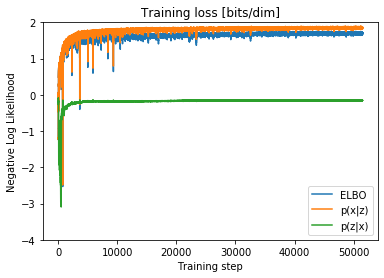

In [17]:
plt.plot(train_elbo_list)
plt.plot(train_log_pxz_list)
plt.plot(train_log_pzx_list)
plt.ylim((-4.0, 2.0))
plt.title('Training loss [bits/dim]')
plt.xlabel('Training step')
plt.legend(['ELBO', 'p(x|z)', 'p(z|x)'])
_ = plt.ylabel('Negative Log Likelihood')

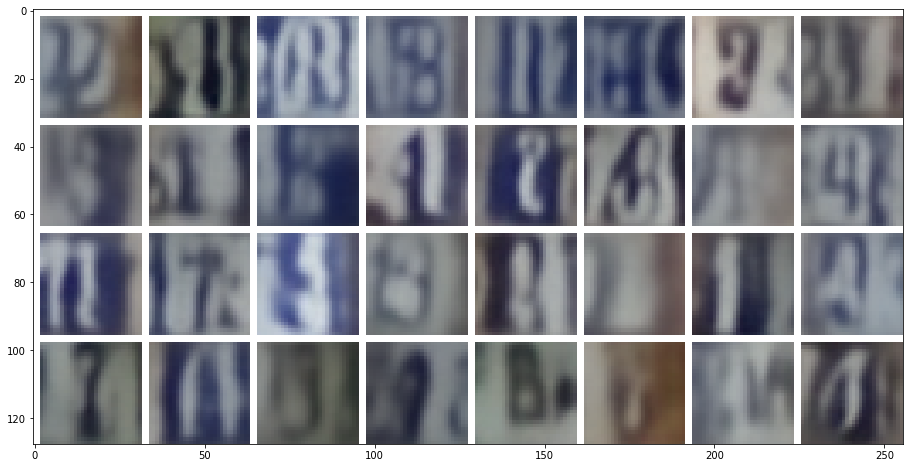

In [18]:
z_ = np.random.randn(32,8,8,latent_nrof_channels)
x_ = np.zeros((32,32,32,3))
x_rec_ = sess.run(eval_dbg['x_rec_mu'], feed_dict={eval_dbg['z']:z_, eval_dbg['x']:x_})
plt.figure(figsize=(16,8))
show_images(x_rec_, 8)